In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

## 1. Q-learning in the wild (3 pts)

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [2]:
def flipCoin(prob):
    return np.random.uniform() < prob

In [3]:
import random,math
import numpy as np
from collections import defaultdict

class QLearningAgent():
  """
    Q-Learning Agent

    Instance variables you have access to
      - self.epsilon (exploration prob)
      - self.alpha (learning rate)
      - self.discount (discount rate aka gamma)

    Functions you should use
      - self.getLegalActions(state)
        which returns legal actions for a state
      - self.getQValue(state,action)
        which returns Q(state,action)
      - self.setQValue(state,action,value)
        which sets Q(state,action) := value

    !!!Important!!!
    NOTE: please avoid using self._qValues directly to make code cleaner
  """
  def __init__(self,alpha,epsilon,discount,getLegalActions):
    "We initialize agent and Q-values here."
    self.getLegalActions= getLegalActions
    self._qValues = defaultdict(lambda:defaultdict(lambda:0))
    self.alpha = alpha
    self.epsilon = epsilon
    self.discount = discount

  def getQValue(self, state, action):
    #print(state)
    #print(action)
    if not (state in self._qValues) or not (action in self._qValues[state]):
        return 0.0
    return self._qValues[state][action]

  def setQValue(self,state,action,value):
    """
      Sets the Qvalue for [state,action] to the given value
    """
    self._qValues[state][action] = value

#---------------------#start of your code#---------------------#

  def getValue(self, state):
    """
      Returns max_action Q(state,action)
      where the max is over legal actions.
    """

    possibleActions = self.getLegalActions(state)
    #If there are no legal actions, return 0.0
    if len(possibleActions) == 0: return 0.0
    return max(self.getQValue(state, action) for action in possibleActions)

  def getPolicy(self, state):
    """
      Compute the best action to take in a state.

    """
    possibleActions = self.getLegalActions(state)
    if len(possibleActions) == 0: return None
    return max(possibleActions, key = lambda action: self.getQValue(state, action))

  def getAction(self, state):
    """
      Compute the action to take in the current state, including exploration.

      With probability self.epsilon, we should take a random action.
      otherwise - the best policy action (self.getPolicy).

      HINT: You might want to use util.flipCoin(prob)
      HINT: To pick randomly from a list, use random.choice(list)

    """

    if flipCoin(self.epsilon):
      return np.random.choice(self.getLegalActions(state))
    return self.getPolicy(state)

  def update(self, state, action, nextState, reward):
    """
      You should do your Q-Value update here

      NOTE: You should never call this function,
      it will be called on your behalf


    """
    #agent parameters
    gamma = self.discount
    learning_rate = self.alpha

    "*** YOUR CODE HERE ***"
    self.setQValue(state, action, (1 - learning_rate) * self.getQValue(state, action) + learning_rate * (reward + gamma * self.getValue(nextState)))

In [4]:
import gym
env = gym.make("Taxi-v3")
n_actions = env.action_space.n

In [5]:
def play_and_train(env,agent,t_max=10**4):
    """This function should
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.getAction(s)

        next_s,r,done,_ = env.step(a)

        agent.update(s, a, next_s, r)

        s = next_s
        total_reward +=r
        if done:break

    return total_reward

In [6]:
agent = QLearningAgent(alpha=0.5,epsilon=0.9,discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

Достигните положительной награды, постройте график

In [7]:
def get_epsilon(play_id):
    return 1 - 1 / (1 + play_id ** (-1/2))

0.03224073559956364


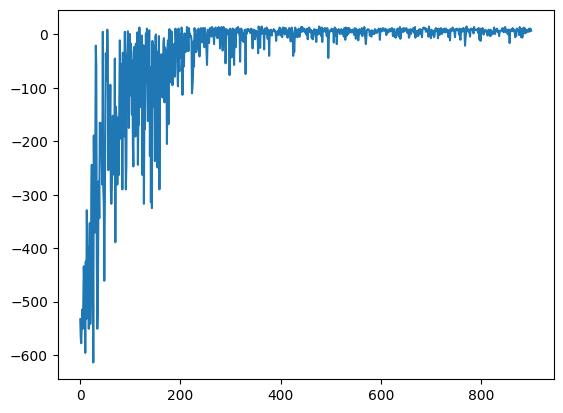

In [8]:
from IPython.display import clear_output
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env,agent))
    agent.epsilon = get_epsilon(i + 1)
    if i % 100 == 0:
        clear_output(True)
        print(agent.epsilon)
        plt.plot(rewards)
        plt.show()


## 3. Continuous state space (2 pt)

Чтобы использовать табличный q-learning на continuous состояниях, надо как-то их обрабатывать и бинаризовать. Придумайте способ разбивки на дискретные состояния.

In [9]:
env = gym.make("CartPole-v0")
n_actions = env.action_space.n
print("first state:%s"%(env.reset()))

first state:[-0.01466015  0.04046569 -0.03255251  0.03207654]


In [24]:
visited_states = []

for i in range(1000):
    s = env.reset()
    visited_states.append(s)
    
    for _ in range(1000):
        a = np.random.choice(range(n_actions))
        next_s,r,done,_ = env.step(a)

        s = next_s

        visited_states.append(next_s)

        if done:break

### Play a few games

Постройте распределения различных частей состояния игры. Сыграйте несколько игр и запишите все состояния.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_4543/1785021042.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


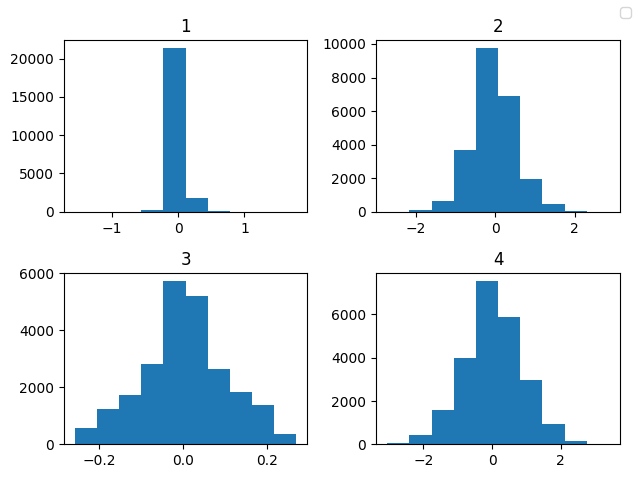

In [29]:
q = list(zip(*visited_states))
f, ax = plt.subplots(2, 2)

ax[0][0].hist(q[0])
ax[0][0].set_title("1")

ax[0][1].hist(q[1])
ax[0][1].set_title("2")

ax[1][0].hist(q[2])
ax[1][0].set_title("3")

ax[1][1].hist(q[3])
ax[1][1].set_title("4")

f.legend()
f.tight_layout()

f.show()

## Binarize environment

In [47]:
from gym.core import ObservationWrapper
class Binarizer(ObservationWrapper):

    def to_bin(self, value, bins):
        return value // bins

    def observation(self,state):

        state = (self.to_bin(state[0], 0.1), self.to_bin(state[1], 0.1), self.to_bin(state[2], 0.01), self.to_bin(state[3], 0.1))

        return state

In [48]:
env = Binarizer(gym.make("CartPole-v0"))

## Learn

In [49]:
agent = QLearningAgent(alpha=0.5,epsilon=0.9,discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

0.09090909090909094
195.16
Win!


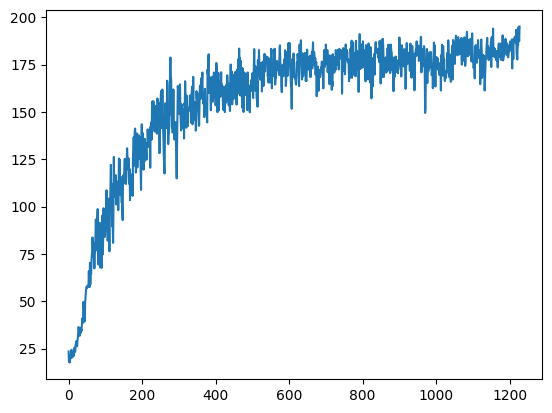

In [50]:
rewards = []
rewBuf = []
ma = -1000000000000
for i in range(10000):
    for i in range(100):
        rewards.append(play_and_train(env,agent))
    agent.epsilon = get_epsilon(i + 1)
    rewBuf.append(np.mean(rewards[-100:]))
    clear_output(True)
    print(agent.epsilon)
    print(rewBuf[-1])
    plt.plot(rewBuf)
    if(rewBuf[-1] > 195):
        print("Win!")
        break
    plt.show()


## 4. Experience replay (5 pts)

In [62]:
import random
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._replaceId = 0


    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize.
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        if len(self._storage) == self._maxsize:
            self._storage.pop(0)
        self._storage.append(data)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """

        if len(self._storage) == 1 and batch_size == 1: return self._storage[0]

        inds = np.random.choice(np.array([i for i in range(self.__len__())]), batch_size)

        ob, ab, rb, nb, db = [], [], [], [], []
        for i in inds:
            ob.append(self._storage[i][0])
            ab.append(self._storage[i][1])
            rb.append(self._storage[i][2])
            nb.append(self._storage[i][3])
            db.append(self._storage[i][4])

        return ob, ab, rb, nb, db


Some tests to make sure your buffer works right

In [63]:
import numpy as np
replay = ReplayBuffer(2)
obj1 = tuple(range(5))
obj2 = tuple(range(5, 10))
replay.add(*obj1)
assert replay.sample(1)==obj1, "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay._storage)==2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay._storage)==2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100))==obj2
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100))==2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100))==obj1
print ("Success!")

Success!


Now let's use this buffer to improve training:

In [64]:
import gym
env = Binarizer(gym.make('CartPole-v0'))
n_actions = env.action_space.n

In [65]:
agent = QLearningAgent(alpha=0.5,epsilon=0.9,discount=0.99,
                       getLegalActions = lambda s: range(n_actions))
replay = ReplayBuffer(10000)

In [66]:
def play_and_train(env, agent, t_max=10**4, batch_size=10):
    """This function should
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        action = agent.getAction(s)
        next_s, r, done,_ = env.step(action)

        replay.add(s, action, r, next_s, done)

        s = next_s
        total_reward += r
        if done:break

    ob, ab, rb, nb, db = replay.sample(batch_size)

    for o, a, rw, n, d in zip(ob, ab, rb, nb, db):
        agent.update(o, a, n, rw)

    return total_reward




Train with experience replay

0.09090909090909094
196.84
Win!


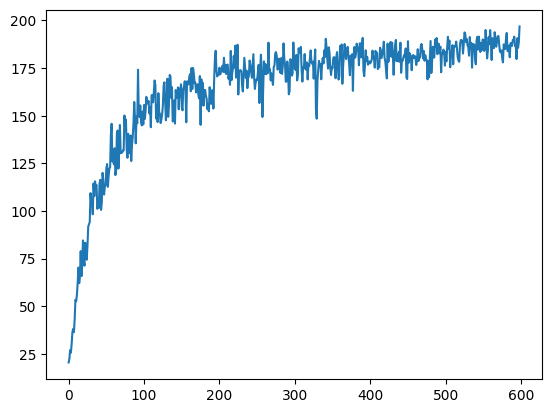

In [67]:
rewards = []
rewBuf = []
ma = -1000000000000
for i in range(10000):
    for i in range(100):
        rewards.append(play_and_train(env,agent, batch_size=1000))
    agent.epsilon = get_epsilon(i + 1)
    rewBuf.append(np.mean(rewards[-100:]))
    clear_output(True)
    print(agent.epsilon)
    print(rewBuf[-1])
    plt.plot(rewBuf)
    if(rewBuf[-1] > 195):
        print("Win!")
        break
    plt.show()
